<a href="https://colab.research.google.com/github/miftahcoiri354/bangkit-final-project/blob/master/Final_Notebook_(Tested)_Signal_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Colab Library to upload files to notebook
from google.colab import files
files.upload() #upload kaggle.json (You can get the files from Kaggle API Token at My Account)

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle kernels list — user miftahcoiri — sort-by dateRun
!kaggle datasets download -d datamunge/sign-language-mnist

In [ ]:
from zipfile import ZipFile

z = ZipFile('sign-language-mnist.zip')
zip_files = z.infolist()

zip_files

In [ ]:
!unzip sign-language-mnist.zip

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import pandas as pd
import numpy as np
import csv
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#**Dataset Preparateion**

In [ ]:
#Import the test and train datasets into pandas dataframe
train_df = pd.read_csv('sign_mnist_train.csv')
test_df = pd.read_csv('sign_mnist_test.csv')
test_df

In [ ]:
old_labels_train = train_df['label']
old_labels_test = test_df['label']

In [ ]:
labels = []
z = 0
y = 10

for i in old_labels_train:
  if z == i:
    labels.append(z)
    z = z+1
labels.append(z)

for i in old_labels_train:
  if y == i:
    labels.append(y)
    y = y+1
#labels.append(y)

In [ ]:
n = labels
def spelli(n):
    n = str(n)
    num = labels
    spell = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
    res = ''
    l = len(n)
    if int(n) in num:
        res = spell[num.index(int(n))]
        return (res)
    elif len(n)==1:
        res = spell[n]
        return (res)
    elif len(n)==2:
        m = n[0]
        m += '0'
        m = int(m)
        res = spell[num.index(m)]+' '
        res += spelli(int(n[1]))
        return (res)

In [ ]:
fin_labels = []
for i in labels:
  n = i
  result = ""
  n = str(n)[::-1]
  arr = [n[i:i+3][::-1] for i in range(0, len(n), 3)]
  jrr = arr[::-1]
  for e in jrr:
    result+= spelli(int(e))
    result+=""
  #print (result)
  fin_labels.append(result)

In [ ]:
new_train_labels = []
new_test_labels = []
for q in train_df['label']:
  for z in labels:
    if q == z:
      new_train_labels.append(fin_labels[z])
for q in test_df['label']:
  for z in labels:
    if q == z:
      new_test_labels.append(fin_labels[z])

In [ ]:
train_df['new_train_labels'] = new_train_labels
test_df['new_test_labels'] = new_test_labels

In [ ]:
x_train = train_df.iloc[:, 1:-1]
x_test = test_df.iloc[:, 1:-1]
y_train = train_df['new_train_labels']
y_test = test_df['new_test_labels']

In [ ]:
final_labels = '\n'.join(fin_labels)

with open('labels.txt', 'w') as f:
  f.write(final_labels)

In [ ]:
train_df
train_df.iloc[:, 1:-1]
x_train

#**Dataset Transformation**

In [ ]:
x_train_resize = x_train/255
x_test_resize = x_test/255
x_train_resize = x_train_resize.values
x_test_resize = x_test_resize.values

In [ ]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
x_train_resize = x_train_resize.reshape(-1,28,28,1)
x_test_resize = x_test_resize.reshape(-1,28,28,1)
x_train_resize.shape

In [ ]:
y_train_preprocessing = preprocessing.LabelBinarizer()
y_test_preprocessing = preprocessing.LabelBinarizer()
y_train_resize = y_train_preprocessing.fit_transform(y_train)
y_test_resize = y_test_preprocessing.fit_transform(y_test)
y_train_resize.shape

In [ ]:
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train_resize[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()   

In [ ]:
# With data augmentation to prevent overfitting
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

#**Build & Train Model**

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(75, (3,3), 
                         strides = 1,
                         padding = 'same',
                         activation='relu',
                         input_shape = (28,28,1)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D((2,2),
                            strides = 2,
                            padding = 'same'),
  tf.keras.layers.Conv2D(50, (3,3),
                         strides=1,
                         padding = 'same',
                         activation = 'relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D((2,2),
                            strides = 2,
                            padding = 'same'),
  tf.keras.layers.Conv2D(25, (3,3),
                         strides = 1,
                         padding = 'same',
                         activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D((2,2),
                            strides=2,
                            padding='same'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=512,
                        activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(units=24,
                        activation = 'softmax')
])

In [ ]:
model.compile(optimizer = 'adam' , 
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

In [ ]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(
                                            monitor='val_accuracy', 
                                            patience = 2, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
history = model.fit(datagen.flow(x_train_resize,y_train_resize, batch_size = 128),
                    epochs = 25 , validation_data = (x_test_resize, y_test_resize),
                    callbacks = [learning_rate_reduction])

In [ ]:
print("Accuracy of the model is - " , model.evaluate(x_test_resize,y_test_resize)[1]*100 , "%")

#**Plot the Prediction Result**

In [ ]:
epochs = [i for i in range(25)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'r-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'b-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'r-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'b-' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
predictions = model.predict_classes(x_test_resize)
for i in range(len(predictions)):
    if(predictions[i] >= 9):
        predictions[i] += 1

print(predictions[:100]) #prediction labels using ML
print(np.array(y_test[:100])) #original labels from dataset

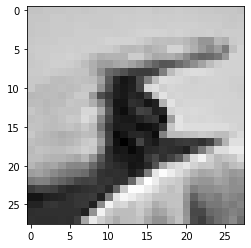

In [52]:
plt.imshow(x_test_resize[0].reshape(28,28), cmap="gray", interpolation='none')

#**Convert the Model into TFLite Model**

In [ ]:
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
from google.colab import files

files.download('model.tflite')
files.download('labels.txt')

#**Interpret & Test the TFLite Model**

In [ ]:
final_model = "model.tflite"
interpreter = tf.lite.Interpreter(model_path=final_model)
interpreter.allocate_tensors()

print("== Input details ==")
print("name:", interpreter.get_input_details()[0]['name'])
print("shape:", interpreter.get_input_details()[0]['shape'])
print("type:", interpreter.get_input_details()[0]['dtype'])

print("\n== Output details ==")
print("name:", interpreter.get_output_details()[0]['name'])
print("shape:", interpreter.get_output_details()[0]['shape'])
print("type:", interpreter.get_output_details()[0]['dtype'])

print("\nDUMP INPUT")
print(interpreter.get_input_details()[0])
print("\nDUMP OUTPUT")
print(interpreter.get_output_details()[0])

In [ ]:
print("Image Input Shape:",  x_train_resize[10].shape)

In [ ]:
x_squeeze = x_train_resize.squeeze()
example_img_for_tflite = x_squeeze[10]
plt.grid(False)
plt.xticks([])
plt.yticks([])

print("Squeezed Image:", example_img_for_tflite.shape)
plt.imshow(example_img_for_tflite, cmap=plt.cm.binary)

In [ ]:
example_img_for_tflite = example_img_for_tflite.reshape(1,28,28,1)
input_data = np.array(example_img_for_tflite, dtype=np.float32)
print("Input data shape:", input_data.shape)
print("Input data type:", input_data.dtype)

In [ ]:
input_details = interpreter.get_input_details()
print(interpreter.get_input_details())

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

In [ ]:
output_details = interpreter.get_output_details()
output_data = interpreter.get_tensor(output_details[0]['index'])
print("\n\nPrediction results:", output_data)
print("Predicted value:", np.argmax(output_data))



---
#**Try with Real Images (Optional)**


In [ ]:
from PIL import Image
import PIL.ImageOps    

img = Image.open("test.png").convert('L')
img.load()
img = PIL.ImageOps.invert(img)
data = np.asarray( img, dtype="int32" )

plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.imshow(data, cmap=plt.cm.binary)

data = data / 255.0
inputImg = np.expand_dims(data,0).astype(np.float32)
inputImg.shape

input_details = interpreter.get_input_details()
interpreter.set_tensor(input_details[0]['index'], inputImg)

interpreter.invoke()

output_details = interpreter.get_output_details()
output_data = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results:", output_data)
print("Predicted value:", np.argmax(output_data))